In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
%ls

drive/  sample_data/


- data_path = "/content/drive/My Drive/Colab Notebooks/Data"
- py_path = "/content/drive/My Drive/Colab Notebooks/Python"

In [ ]:
%cd "/content/drive/My Drive/Colab Notebooks/Python"
import warnings
import pickle
from fastai import *
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
from sklearn.metrics import mean_squared_error, mean_absolute_error
import time
pd.set_option('display.float_format', lambda x: '%.4f' % x)
from error_metrics_2020_July import *
from darnn_network_russia import *

[Errno 2] No such file or directory: '/content/drive/My Drive/Colab Notebooks/Python'
/content


ModuleNotFoundError: ignored

In [ ]:
from torch import tensor, Tensor
from torch import optim
from torch.utils.data import TensorDataset, DataLoader
import pickle

In [ ]:
%cd "/content/drive/My Drive/Colab Notebooks/Data"
#%ls
# Dataset is now stored in a Pandas Dataframe.
target_name = 'Ibm_5min'
ibm_5min = pd.read_csv("data_final_IBM_5.csv")
ibm_5min.columns
ibm_5min.rename(columns={'close': target_name}, inplace=True)
ibm_5min.drop(['mon','wday','mday','yday','return'], axis=1, inplace=True)
data = ibm_5min

/content/drive/My Drive/Colab Notebooks/Data


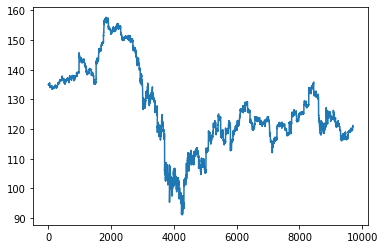

In [ ]:
data[target_name].plot()

In [ ]:
data.shape

(9701, 51)

In [ ]:
batch_size = 128
timesteps = 10 # lookback
n_timeseries = data.shape[1] - 1
val_length = 500
test_length = 500
train_length = data.shape[0]-val_length-test_length-1
prediction_horizon = 1

X = np.zeros((len(data), timesteps, data.shape[1]-1))
y = np.zeros((len(data), timesteps, 1))
#---
for i, name in enumerate(list(data.columns[:-1])):
  for j in range(timesteps):
    X[:, j, i] = data[name].shift(timesteps - j - 1).fillna(method="bfill")

for j in range(timesteps):
  y[:,j,0] = data[target_name].shift(timesteps - j - 1).fillna(method='bfill')
#---
# make lag variable
prediction_horizon=1
target = data[target_name].shift(-prediction_horizon).fillna(method='ffill').values

# start from timstep because we bfilled
X=X[timesteps:]
y=y[timesteps:]
target=target[timesteps:]

X_train = X[:train_length]
y_his_train = y[:train_length]
X_val = X[train_length:train_length+val_length]
y_his_val = y[train_length:train_length+val_length]
X_test = X[-val_length:]
y_his_test = y[-val_length:]
target_train = target[:train_length]
target_val = target[train_length:train_length+val_length]
target_test = target[-val_length:]

X_train_max = X_train.max(axis=0)
X_train_min = X_train.min(axis=0)
y_his_train_max = y_his_train.max(axis=0)
y_his_train_min = y_his_train.min(axis=0)
target_train_max = target_train.max(axis=0)
target_train_min = target_train.min(axis=0)

# Normalize based on training data
# Use it to recover back to original series

X_train = (X_train - X_train_min) / (X_train_max - X_train_min)
X_val = (X_val - X_train_min) / (X_train_max - X_train_min)
X_test = (X_test - X_train_min) / (X_train_max - X_train_min)

y_his_train = (y_his_train - y_his_train_min) / (y_his_train_max - y_his_train_min)
y_his_val = (y_his_val - y_his_train_min) / (y_his_train_max - y_his_train_min)
y_his_test = (y_his_test - y_his_train_min) / (y_his_train_max - y_his_train_min)

target_train = (target_train - target_train_min) / (target_train_max - target_train_min)
target_val = (target_val - target_train_min) / (target_train_max - target_train_min)
target_test = (target_test - target_train_min) / (target_train_max - target_train_min)

X_train_t = torch.Tensor(X_train)
X_val_t = torch.Tensor(X_val)
X_test_t = torch.Tensor(X_test)
y_his_train_t = torch.Tensor(y_his_train)
y_his_val_t = torch.Tensor(y_his_val)
y_his_test_t = torch.Tensor(y_his_test)
target_train_t = torch.Tensor(target_train)
target_val_t = torch.Tensor(target_val)
target_test_t = torch.Tensor(target_test)
target_test_t.dtype, target_val_t.dtype, target_test_t.dtype

train_loader = DataLoader(TensorDataset(X_train_t, y_his_train_t, target_train_t), shuffle=True, batch_size=batch_size)
val_loader = DataLoader(TensorDataset(X_val_t, y_his_val_t, target_val_t), shuffle=False, batch_size=batch_size)
test_loader = DataLoader(TensorDataset(X_test_t, y_his_test_t, target_test_t), shuffle=False, batch_size=batch_size)

In [ ]:
model = DARNN(X_train.shape[2], 128, 128, X_train.shape[1]).cuda()
opt = torch.optim.Adam(model.parameters(), lr=0.001)
epoch_scheduler = torch.optim.lr_scheduler.StepLR(opt, 20, gamma=0.9)

Saving...
7.9735678017268885
Iter:  0 train:  0.23802507902190978 val:  0.05007990277135679
Iter time:  3.240374194999731
rmse:  3.3360724 mae:  2.8262036
lr:  0.001


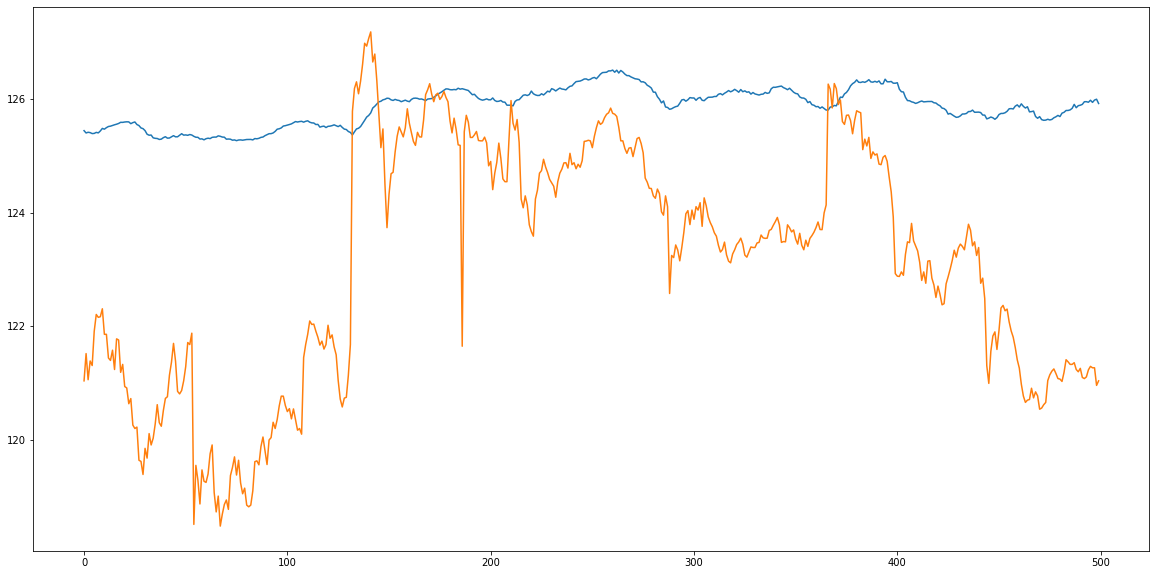

Saving...
4.9435114211770825
Iter:  1 train:  0.08900797732497807 val:  0.04770020232570072
Iter time:  3.1353393169997616
Saving...
15.558806002807835
Iter:  2 train:  0.029544896487089915 val:  0.026167661275173334
Iter time:  3.0977627649999704
Saving...
-7.788474540430812
Iter:  3 train:  0.025117265686860575 val:  0.020658852765763368
Iter time:  3.270010346000163
Saving...
6.683395312863927
Iter:  4 train:  0.02181509090138653 val:  0.02055782016566328
Iter time:  3.0811279740000828
Saving...
13.040497291351194
Iter:  5 train:  0.019949634271058767 val:  0.020050866396302568
Iter time:  3.11313775599956
Saving...
-9.045066250248668
Iter:  6 train:  0.017736293043616062 val:  0.01567277885130519
Iter time:  3.0667992329999834
Iter:  7 train:  0.01703981213973534 val:  0.016500926990325078
Iter time:  3.101018811999893
Iter:  8 train:  0.016719315216205073 val:  0.016603555636811516
Iter time:  3.180731267000283
Saving...
-7.043088226252825
Iter:  9 train:  0.017186527760973538 val

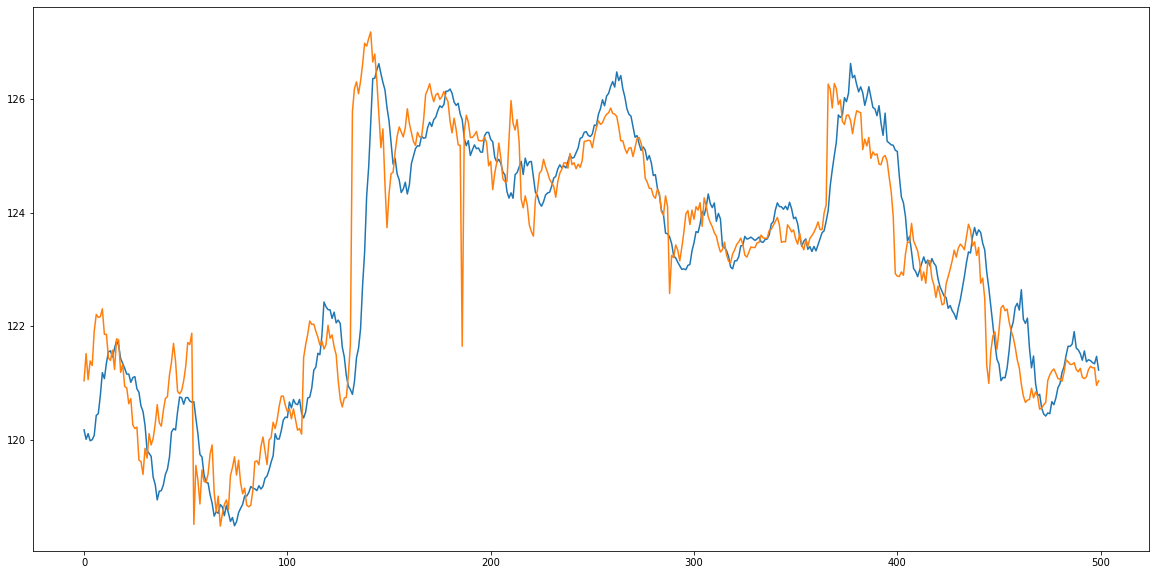

Saving...
-19.802856895012344
Iter:  11 train:  0.014745086199942558 val:  0.013497697531597732
Iter time:  3.149150101000032
Iter:  12 train:  0.014401895554501566 val:  0.014044919533799648
Iter time:  3.0426200030001382
Iter:  13 train:  0.014331248731757364 val:  0.019828535629383814
Iter time:  3.034782906000146
Saving...
-20.563152339334568
Iter:  14 train:  0.015745840971267164 val:  0.01333481585887447
Iter time:  3.1478396299999076
Saving...
-11.747079151246066
Iter:  15 train:  0.014980317335384793 val:  0.012342076025381506
Iter time:  3.061233185999754
Iter:  16 train:  0.013707046621720452 val:  0.017195148053329654
Iter time:  3.108005993000006
Iter:  17 train:  0.013792204983905269 val:  0.014039110519502719
Iter time:  2.9662294790000487
Saving...
-17.942241124362813
Iter:  18 train:  0.01380149212614953 val:  0.012155065708591253
Iter time:  3.071164656000292
Iter:  19 train:  0.013496035338739531 val:  0.012155650447298638
Iter time:  3.027973820999705
Iter:  20 train

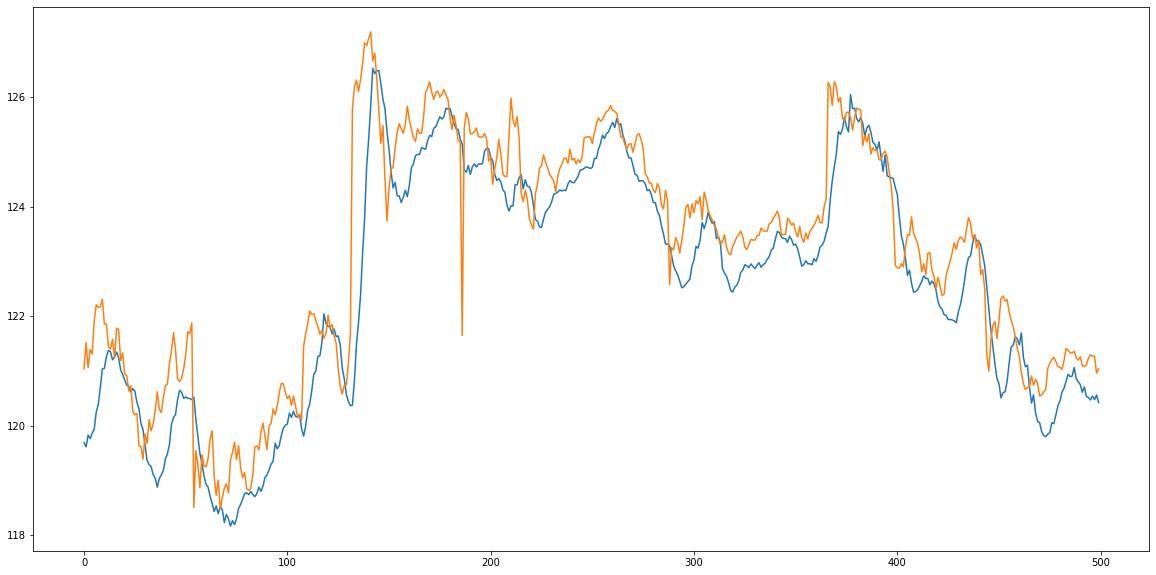

Iter:  21 train:  0.012833667127974588 val:  0.01314750883918159
Iter time:  3.1367215029999898
Iter:  22 train:  0.013939569846134063 val:  0.012872438873333633
Iter time:  3.0810569340001166
Saving...
-7.727363429188716
Iter:  23 train:  0.01330100127628114 val:  0.011383641964281179
Iter time:  3.0251886010000817
Saving...
-12.135848887377698
Iter:  24 train:  0.013763733014200863 val:  0.011217817369321734
Iter time:  3.0414546169999994
Iter:  25 train:  0.01298862873280705 val:  0.011381658951497335
Iter time:  3.0592475660000673
Saving...
-13.196053116618334
Iter:  26 train:  0.013703422441767626 val:  0.010929806434968072
Iter time:  3.140857578000123
Iter:  27 train:  0.013467757672120476 val:  0.011200791488535054
Iter time:  3.0633172080001714
Saving...
-15.511564339045892
Iter:  28 train:  0.012627976063515498 val:  0.010776659898775302
Iter time:  3.1031680350001807
Saving...
-17.5181917982843
Iter:  29 train:  0.011706971075339214 val:  0.010711798305774576
Iter time:  3.0

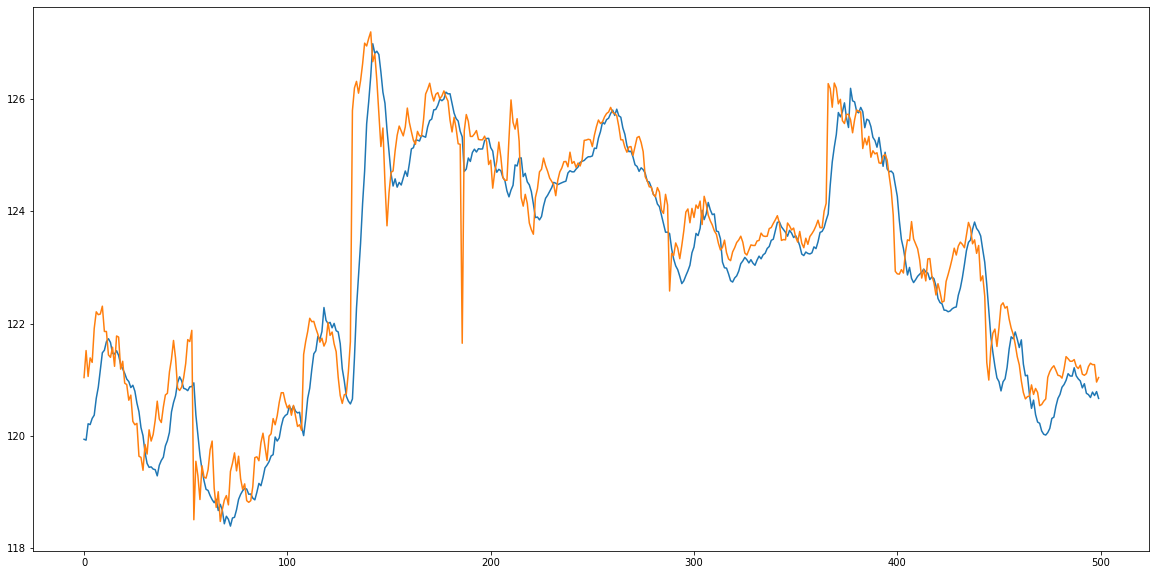

Iter:  31 train:  0.011387037845025002 val:  0.011119845829696558
Iter time:  3.0239214469997933
Iter:  32 train:  0.011803559344989256 val:  0.010722109071370983
Iter time:  3.1539361750001262
Iter:  33 train:  0.011790087923428415 val:  0.010971707997945532
Iter time:  3.028045373999703
Saving...
-18.202108398102546
Iter:  34 train:  0.011281487728317406 val:  0.00998111094722404
Iter time:  3.006052195000393
Iter:  35 train:  0.01201579517473839 val:  0.010049757916180695
Iter time:  3.0458810650002306
Iter:  36 train:  0.011664702197912227 val:  0.011328435276464318
Iter time:  3.072044273999836
Iter:  37 train:  0.011163628561615662 val:  0.010914408728417882
Iter time:  3.071845521999876
Iter:  38 train:  0.010975920000177282 val:  0.014354388648875002
Iter time:  3.077889914000025
Iter:  39 train:  0.011672599250281239 val:  0.010181583133213582
Iter time:  2.993449557999611
Iter:  40 train:  0.01068905558601456 val:  0.011325960150271822
Iter time:  2.9871423720001076
rmse:  0.

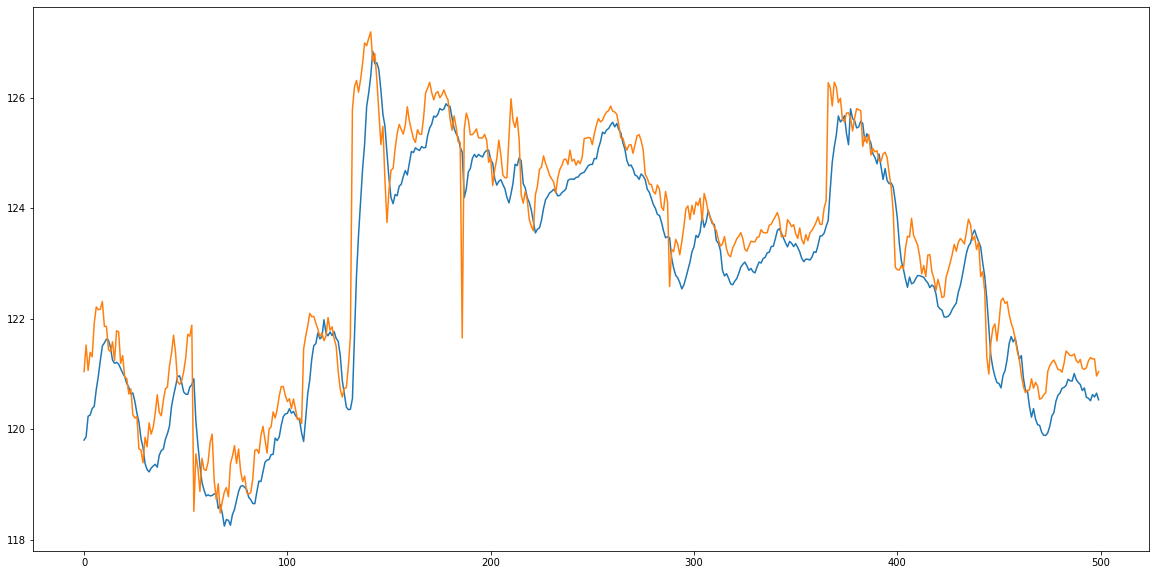

Saving...
-31.51845315174826
Iter:  41 train:  0.010466345084119479 val:  0.009231327709523136
Iter time:  3.078472447999957
Iter:  42 train:  0.010372311638024495 val:  0.009283439128666509
Iter time:  3.1202780389999134
Iter:  43 train:  0.010248043436332833 val:  0.009711633923821392
Iter time:  3.034560152999802
Iter:  44 train:  0.010772504963807453 val:  0.009440159152476445
Iter time:  3.0379610240001966
Saving...
-18.548812975599304
Iter:  45 train:  0.00995631356097725 val:  0.009014707610544919
Iter time:  3.0532020980003836
Saving...
-27.83956913874521
Iter:  46 train:  0.010521301170856527 val:  0.008774480335848238
Iter time:  3.0465207110000847
Saving...
-35.4034632586854
Iter:  47 train:  0.009891178844175341 val:  0.008621593971736214
Iter time:  3.1163523919999534
Iter:  48 train:  0.010147679724564226 val:  0.008692480294496126
Iter time:  2.943906278000213
Iter:  49 train:  0.009960313722294271 val:  0.01013656773723451
Iter time:  3.0931945469997117
Saving...
-34.33

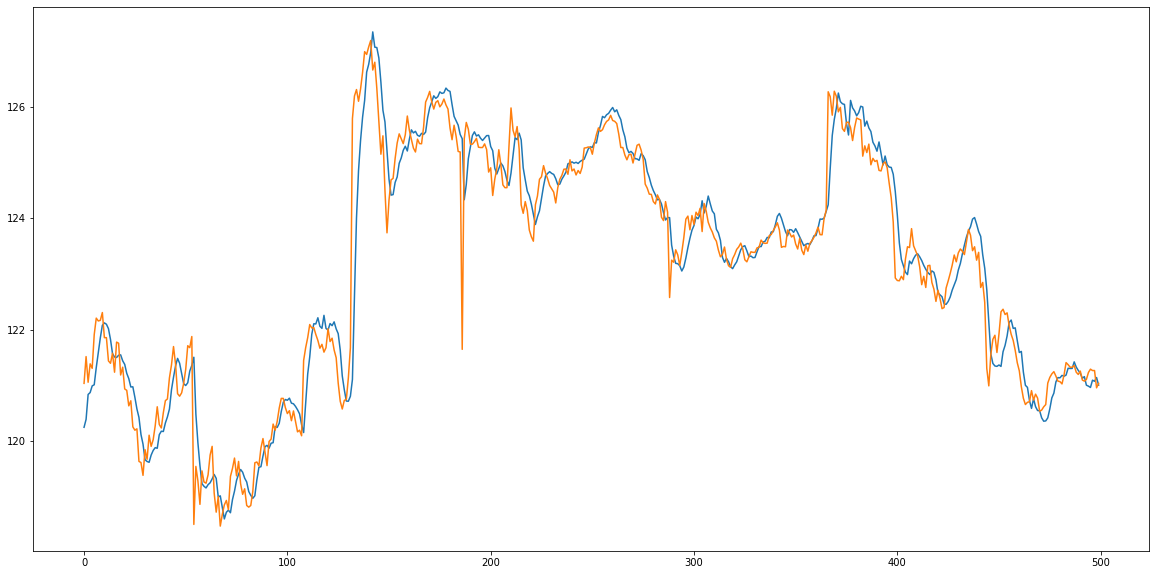

Iter:  51 train:  0.010266052185798161 val:  0.008938547920898493
Iter time:  3.1024158730001545
Iter:  52 train:  0.009533584166586173 val:  0.008914390502491654
Iter time:  3.0603821740000967
Iter:  53 train:  0.009848531234091006 val:  0.008799575777934712
Iter time:  3.0621225310001137
Iter:  54 train:  0.009130063618500252 val:  0.00882453657415806
Iter time:  3.0844363450000856
Iter:  55 train:  0.009340468944161975 val:  0.009176158519967635
Iter time:  3.098723779000011
Saving...
-27.877526893285452
Iter:  56 train:  0.010495441056751062 val:  0.008313341453587057
Iter time:  3.0371328480000557
Iter:  57 train:  0.00890975891966531 val:  0.009273624228236618
Iter time:  3.0616716419999648
Saving...
-25.117523880464244
Iter:  58 train:  0.009013682090115889 val:  0.007870993139156988
Iter time:  3.0617538180003976
Iter:  59 train:  0.00927180342115336 val:  0.010011633547507047
Iter time:  3.124174393999965
Iter:  60 train:  0.009198624975230543 val:  0.008155040710609567
Iter t

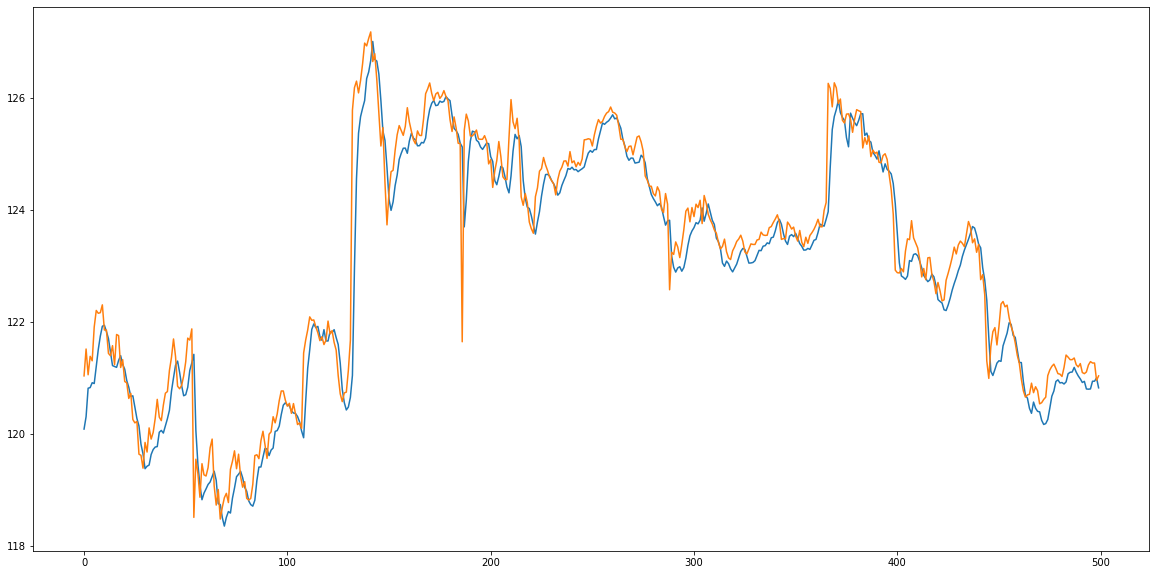

Iter:  61 train:  0.008797399186764622 val:  0.00888736883441046
Iter time:  3.0407546910000747
Saving...
-34.98745428256033
Iter:  62 train:  0.00867933950750673 val:  0.007556119413797114
Iter time:  3.1374142690001463
Iter:  63 train:  0.008279949324434474 val:  0.008201531982147073
Iter time:  3.0302863799997795
Saving...
-16.172397203138324
Iter:  64 train:  0.008520019370993503 val:  0.007338375395424932
Iter time:  3.0674069130000134
Saving...
-9.610864864825396
Iter:  65 train:  0.008309915662527869 val:  0.007297094653985182
Iter time:  3.1293746510000346
Iter:  66 train:  0.008756404909308872 val:  0.008235454052533099
Iter time:  3.1299245380000684
Iter:  67 train:  0.00859088869807204 val:  0.007376790838862153
Iter time:  3.0364697919999344
Iter:  68 train:  0.00843484150460774 val:  0.0074118495350301425
Iter time:  3.130239956999958
Iter:  69 train:  0.008592811766925805 val:  0.00848789719602263
Iter time:  3.1293348819999665
Saving...
-7.7027455954401525
Iter:  70 trai

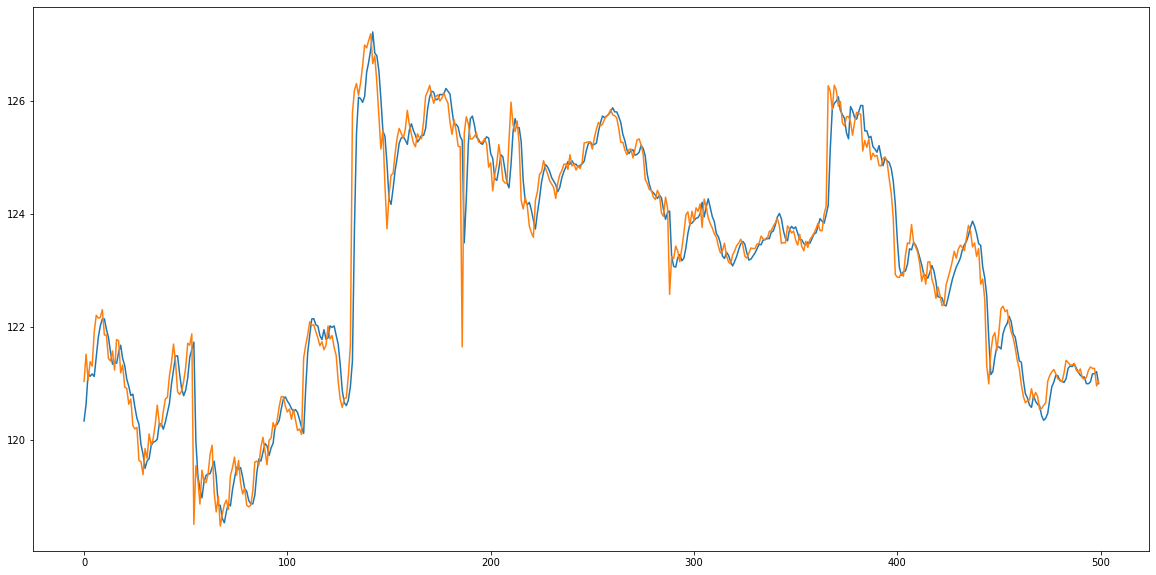

Iter:  71 train:  0.00843079039260289 val:  0.007382483686926765
Iter time:  3.0539623599997867
Saving...
-3.9062648279303502
Iter:  72 train:  0.00855893826045174 val:  0.007069421744884724
Iter time:  3.1375130379997245
Iter:  73 train:  0.008148206310577229 val:  0.007284321080331578
Iter time:  3.0451694469998074
Iter:  74 train:  0.008663125003307064 val:  0.0076635055092304435
Iter time:  3.1279101219997756
Saving...
-4.024701519674045
Iter:  75 train:  0.008188181250513613 val:  0.007051852834078109
Iter time:  3.013191893000112
Iter:  76 train:  0.00800836192157575 val:  0.008967787541013647
Iter time:  3.150042678000318
Iter:  77 train:  0.008279284380668273 val:  0.007242960753820649
Iter time:  3.1529334399997424
Iter:  78 train:  0.008576957293425901 val:  0.007538412893915965
Iter time:  3.0705175099997177
Saving...
-17.449824972467066
Iter:  79 train:  0.008292424752940668 val:  0.0070048785684369425
Iter time:  3.144771469999796
Iter:  80 train:  0.008160053542832292 val

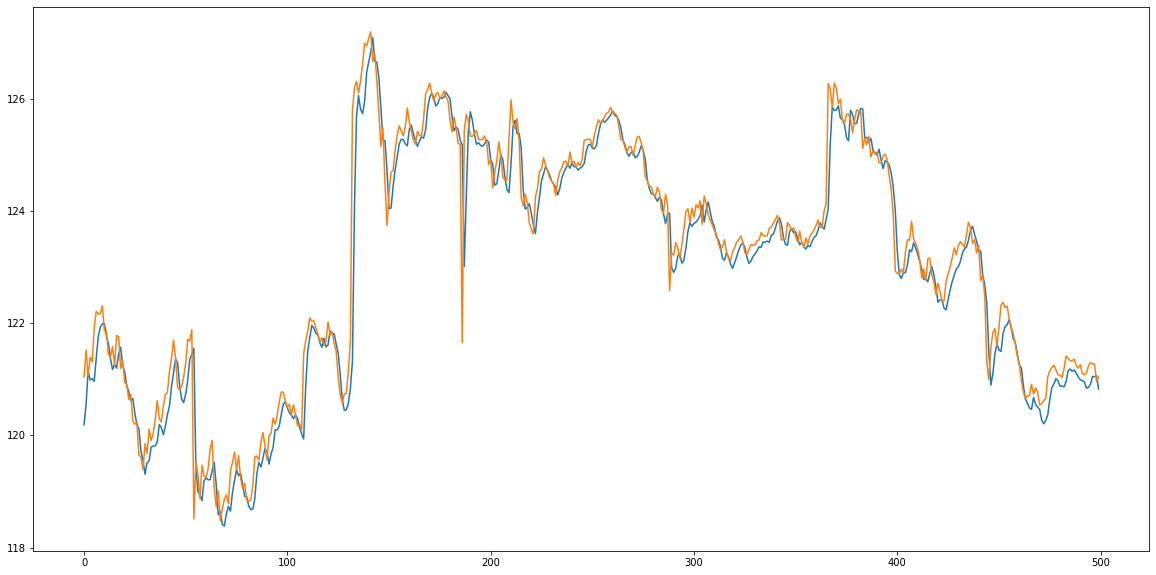

Iter:  81 train:  0.007910479409345472 val:  0.007345512036790535
Iter time:  3.159940118999657
Saving...
-2.4080719844209453
Iter:  82 train:  0.008163557163398621 val:  0.006965529704230581
Iter time:  3.0902149619996635
Iter:  83 train:  0.007984069518960357 val:  0.007088005375839865
Iter time:  3.0218821399998888
Iter:  84 train:  0.00793268417622841 val:  0.007341771244220679
Iter time:  3.0352053700003125
Iter:  85 train:  0.007896971385894831 val:  0.007988140632807112
Iter time:  3.107749035999859
Saving...
-4.003018098871025
Iter:  86 train:  0.007549990844040445 val:  0.0067864575218813845
Iter time:  3.110317505999774
Iter:  87 train:  0.007652039068876611 val:  0.007872421426145347
Iter time:  3.0553793939998286
Iter:  88 train:  0.008307078317406685 val:  0.007981765130497281
Iter time:  3.077671820999967
Iter:  89 train:  0.007706098749420378 val:  0.008966290167271448
Iter time:  3.147845012000289
Iter:  90 train:  0.007664446702624896 val:  0.007449364206003115
Iter ti

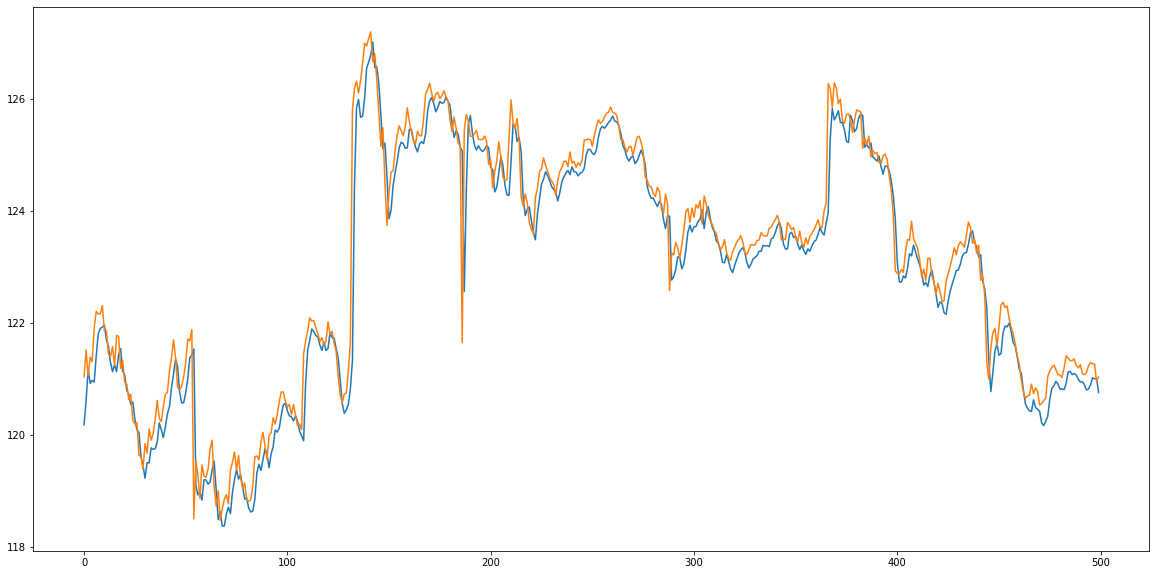

Iter:  91 train:  0.007515450187538904 val:  0.007846776256444771
Iter time:  3.096164081999632
Iter:  92 train:  0.007694369126891941 val:  0.008911938980294225
Iter time:  3.0078868300001886
Iter:  93 train:  0.008044881977110807 val:  0.006938432973163375
Iter time:  3.130755377999776
Saving...
-21.052153003864895
Iter:  94 train:  0.007533591935261377 val:  0.006747135987483586
Iter time:  3.0733089700001983
Iter:  95 train:  0.007465557909165855 val:  0.007006580261099815
Iter time:  3.0955530700002782
Iter:  96 train:  0.007528823899713908 val:  0.0069696709546772755
Iter time:  3.1354195419999087
Iter:  97 train:  0.008067823658475658 val:  0.006807867177863615
Iter time:  3.1103914970003643
Iter:  98 train:  0.007579249107585144 val:  0.006941183638947695
Iter time:  3.0345374730000003
Iter:  99 train:  0.008180552966581645 val:  0.008272576325461472
Iter time:  2.98606931500035
Iter:  100 train:  0.007996177222584833 val:  0.006780633045947509
Iter time:  3.116181751000113
rms

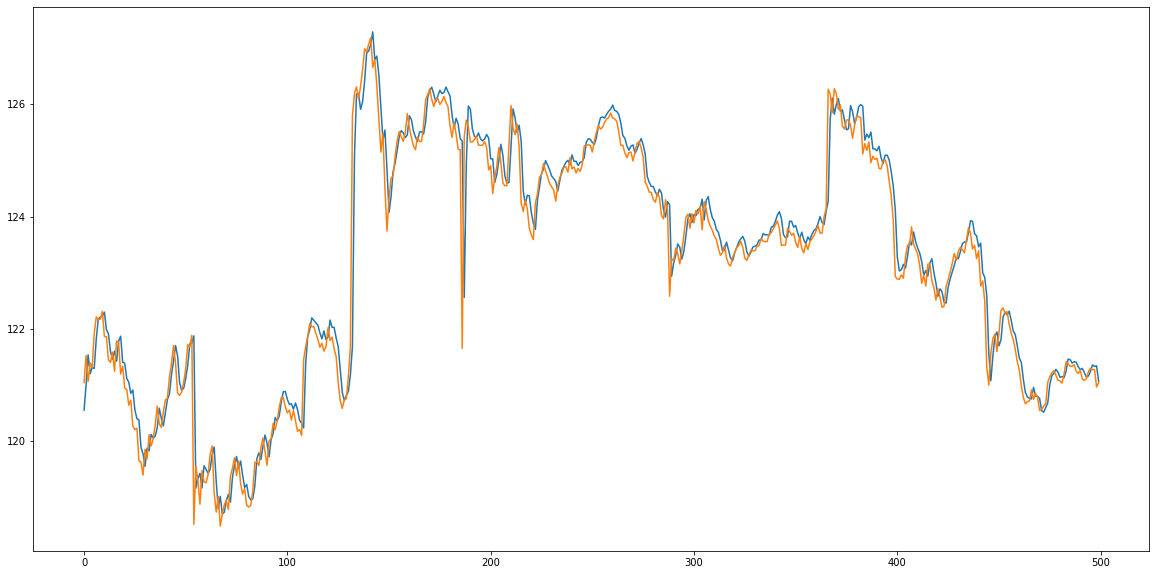

Iter:  101 train:  0.007739167987461349 val:  0.007688171539593734
Iter time:  3.079710250000062
Iter:  102 train:  0.0075668154378817605 val:  0.006839753204660507
Iter time:  3.049313224999878
Iter:  103 train:  0.007662769324665553 val:  0.008086521735427378
Iter time:  2.965516120999837
Iter:  104 train:  0.007394973116334159 val:  0.007415420073554214
Iter time:  3.148531228000138
Iter:  105 train:  0.007392550019938827 val:  0.006751131932225024
Iter time:  3.1280688950000695
Iter:  106 train:  0.00826446425669174 val:  0.0074657021943781736
Iter time:  3.0778954249999515
Saving...
-15.27136733362594
Iter:  107 train:  0.007636850267408966 val:  0.00662881623107009
Iter time:  3.1108309579999514
Iter:  108 train:  0.00734537626909452 val:  0.007623285273724632
Iter time:  3.103527376999864
Iter:  109 train:  0.007625047019426066 val:  0.007479098217955978
Iter time:  3.0987427430000025
Iter:  110 train:  0.007451386123159453 val:  0.00723074160095632
Iter time:  3.064240573999996

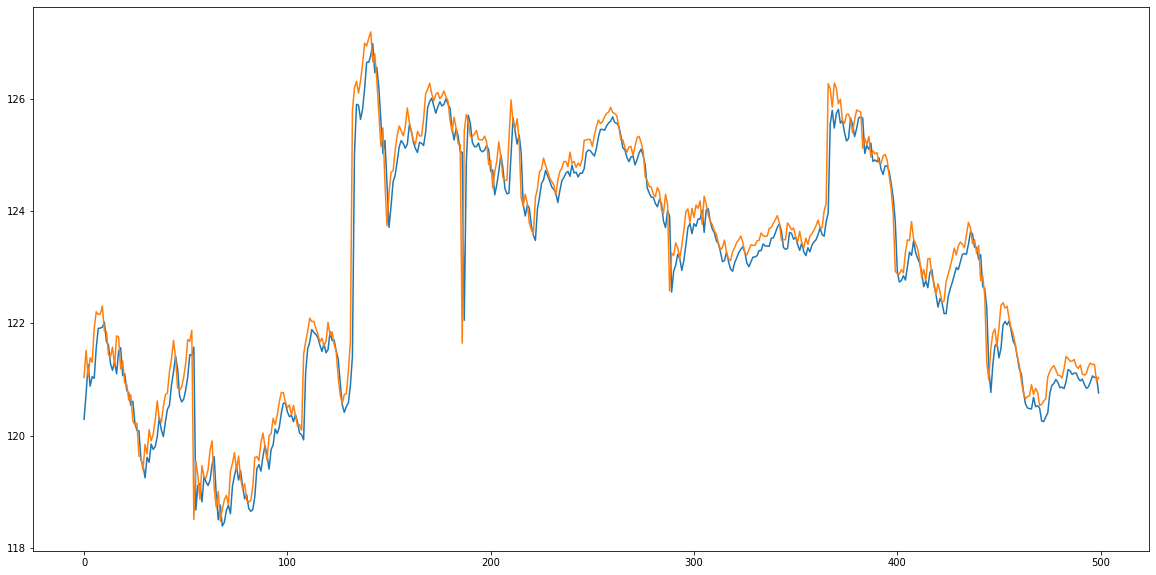

Iter:  111 train:  0.007392931823835488 val:  0.006937878701945558
Iter time:  3.0897621720000643
Iter:  112 train:  0.007808563577151875 val:  0.0071269691206129115
Iter time:  3.056109851999736
Iter:  113 train:  0.007356339715185518 val:  0.006757648523436384
Iter time:  3.0391768590002357
Saving...
-25.08447009673067
Iter:  114 train:  0.007264477515195789 val:  0.006618523885149766
Iter time:  3.1378237009998884
Iter:  115 train:  0.00737254302498962 val:  0.006743156355757456
Iter time:  3.0025207300000147
Iter:  116 train:  0.007520679851785924 val:  0.006766941235528882
Iter time:  3.0460529800002405
Iter:  117 train:  0.0072720656631898774 val:  0.006793728828759436
Iter time:  3.0875799680002274
Iter:  118 train:  0.00765221559920438 val:  0.008478994010122639
Iter time:  3.144056033999732
Iter:  119 train:  0.007669183992865099 val:  0.006774617827085951
Iter time:  3.0801451919996907
Iter:  120 train:  0.00726997731170598 val:  0.006662629186573813
Iter time:  3.01300399299

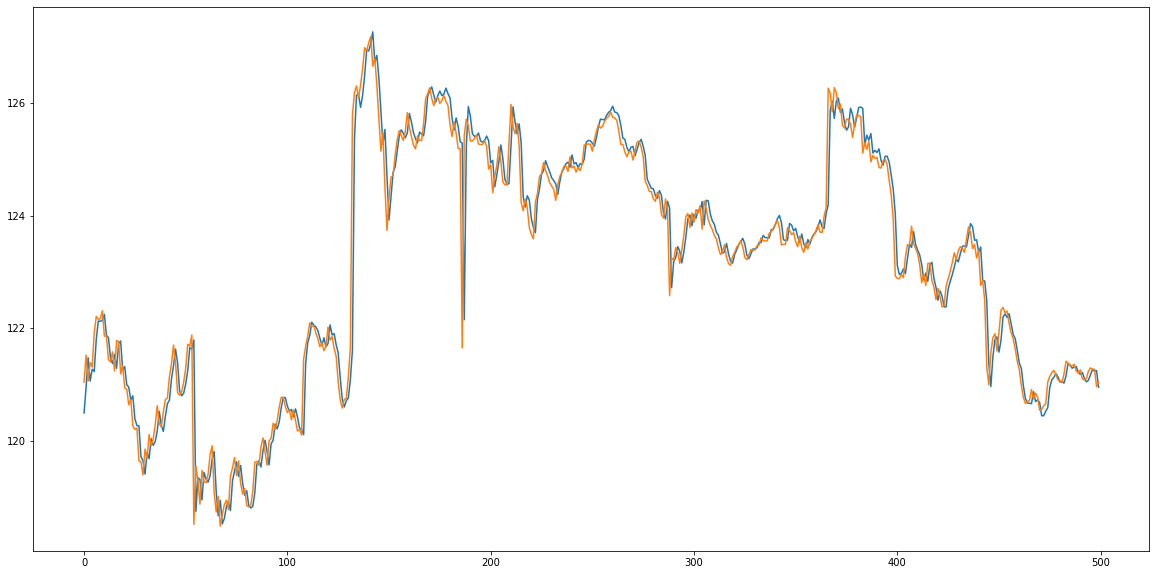

Iter:  121 train:  0.007339209309812725 val:  0.007031427864840045
Iter time:  3.103220984000018
Iter:  122 train:  0.007606465044416217 val:  0.007750444594771232
Iter time:  3.0320568890001596
Saving...
-4.75352891127735
Iter:  123 train:  0.007671533790371341 val:  0.006612595342471103
Iter time:  3.1059769260000394
Saving...
-9.84539713298207
Iter:  124 train:  0.007404240475198177 val:  0.006601918540970773
Iter time:  3.061739381999814
Iter:  125 train:  0.0074333787827637705 val:  0.007319869536286341
Iter time:  3.0946703969998453
Iter:  126 train:  0.0073292866304607305 val:  0.00681978060636097
Iter time:  3.018629551000231
Iter:  127 train:  0.007390397454784291 val:  0.007159487200844334
Iter time:  3.0742955710002207
Iter:  128 train:  0.007139491198718621 val:  0.006778159792165157
Iter time:  3.0314343570003075
Iter:  129 train:  0.0075224656330928966 val:  0.007887777694677158
Iter time:  3.0942883630000324
Saving...
24.023452008671708
Iter:  130 train:  0.0074522848370

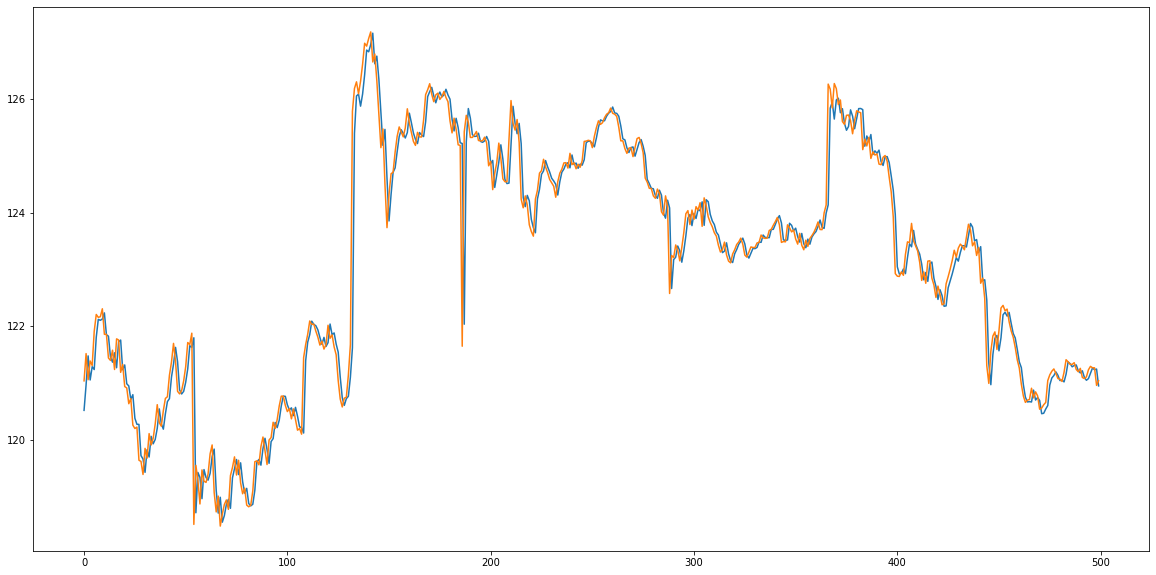

Iter:  131 train:  0.007264585869719944 val:  0.006657768058332499
Iter time:  3.1403894589998345
Iter:  132 train:  0.007208925837332156 val:  0.006914658356185941
Iter time:  3.0518191229998592
Iter:  133 train:  0.007364408602877549 val:  0.008854095820309753
Iter time:  3.1339288920003128
Iter:  134 train:  0.007359528799859417 val:  0.006611374129808987
Iter time:  3.0667175610001323
Iter:  135 train:  0.007300496319745403 val:  0.006748619964635087
Iter time:  2.971690415000012
Iter:  136 train:  0.007336175206109595 val:  0.00661137954547176
Iter time:  3.054840583999976
Iter:  137 train:  0.007749396847430181 val:  0.007281480065321768
Iter time:  3.0547452329997213
Iter:  138 train:  0.007447248978076337 val:  0.00659370376789951
Iter time:  3.0182670819999657
Iter:  139 train:  0.007375664815455616 val:  0.006834880200006756
Iter time:  2.942941769999834
Iter:  140 train:  0.007305977220306081 val:  0.006622351679829152
Iter time:  2.9473903499997505
rmse:  0.44114816 mae:  0

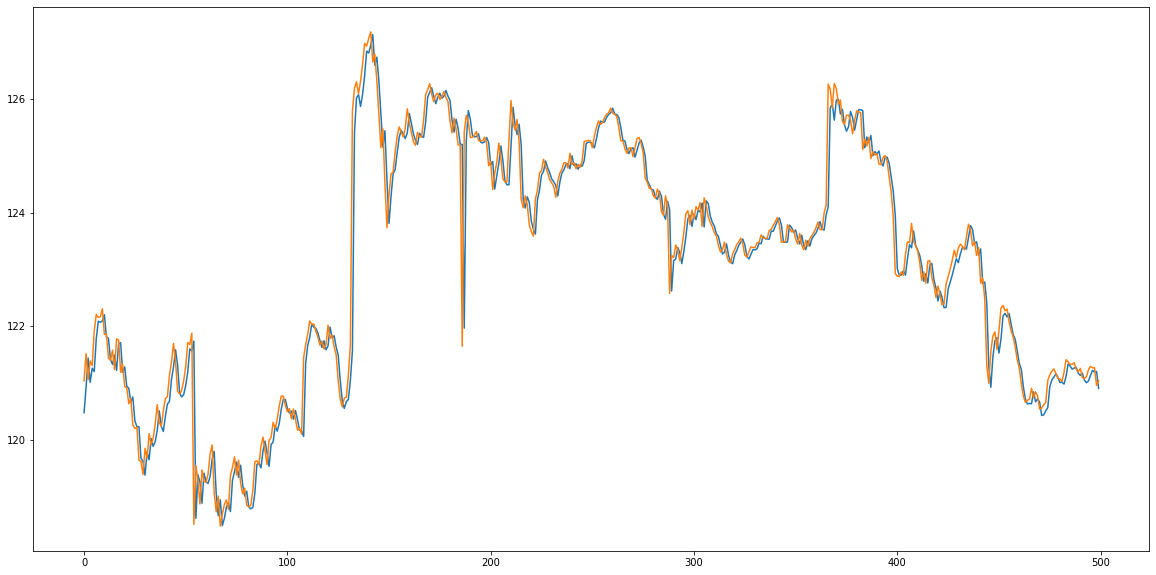

Iter:  141 train:  0.00740682600500181 val:  0.006758256008819342
Iter time:  3.0469395319996693
Iter:  142 train:  0.007570863307684101 val:  0.0067996091176107925
Iter time:  3.139959467999688
Iter:  143 train:  0.007150821149426358 val:  0.006603235280559522
Iter time:  3.103546670000469
Iter:  144 train:  0.007479538542157124 val:  0.0076980937885148554
Iter time:  3.071950139999899
Iter:  145 train:  0.007272896181533106 val:  0.008707335521835847
Iter time:  3.0875812069998574
Iter:  146 train:  0.007262324777700032 val:  0.006697714578697042
Iter time:  3.004325588000029
Iter:  147 train:  0.007467808006469406 val:  0.007063481606906942
Iter time:  3.029938177999611
Iter:  148 train:  0.007271103465342373 val:  0.006626601420314006
Iter time:  3.04051123499994
Iter:  149 train:  0.007413443329083583 val:  0.006686642131884306
Iter time:  3.041158314999848
Iter:  150 train:  0.00717714342204998 val:  0.007430554707640944
Iter time:  3.0411817650001467
rmse:  0.49498633 mae:  0.31

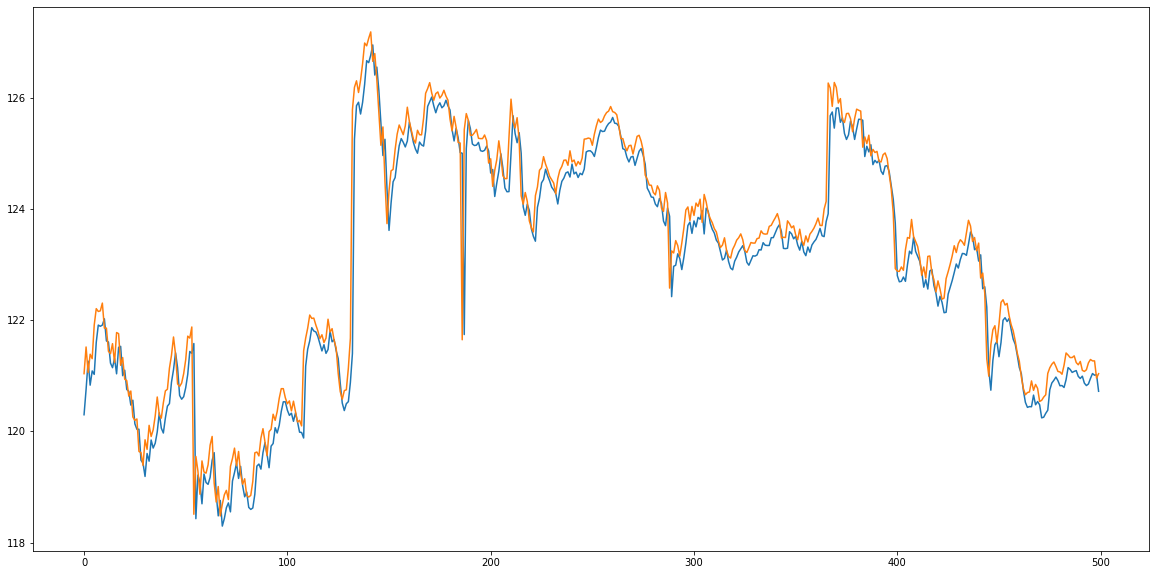

Iter:  151 train:  0.007437829378685976 val:  0.00661219173351505
Iter time:  3.0452977839995583
Iter:  152 train:  0.007714577694100868 val:  0.0066271547568042275
Iter time:  3.014530902999468
Iter:  153 train:  0.007675237433936498 val:  0.006588817809606353
Iter time:  3.0685526380002557
Iter:  154 train:  0.00724785343672733 val:  0.007215872647818058
Iter time:  3.064845599000364
Iter:  155 train:  0.007139178219278188 val:  0.007352687172320079
Iter time:  3.032390915999713
Iter:  156 train:  0.007282713662860397 val:  0.006861616956344375
Iter time:  2.9920527780004704
Iter:  157 train:  0.007362141162127764 val:  0.007065087440009208
Iter time:  2.9879164319991105
Iter:  158 train:  0.0074507230461797165 val:  0.006627829317655799
Iter time:  3.0425125520005167
Iter:  159 train:  0.00726285341681383 val:  0.006634576006224888
Iter time:  3.0652172279997103
reached patience


In [ ]:
epochs = 3000
loss = nn.MSELoss()
patience = 30
min_val_loss = 9999
counter = 0
train_loss=[]
valid_loss=[]
min_profit= 0

for i in range(epochs):
    mse_train = 0
    iteration_start = time.monotonic()
    for batch_x, batch_y_h, batch_y in train_loader :
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        batch_y_h = batch_y_h.cuda()
        opt.zero_grad()
        y_pred,attention,temporal = model(batch_x, batch_y_h)
        y_pred = y_pred.squeeze(1)
        l = loss(y_pred, batch_y)
        l.backward()
        mse_train += l.item()*batch_x.shape[0]
        opt.step()
    epoch_scheduler.step()
    train_loss.append(mse_train)
    with torch.no_grad():
        mse_val = 0
        preds = []
        true = []
        for batch_x, batch_y_h, batch_y in val_loader:
            batch_x = batch_x.cuda()
            batch_y = batch_y.cuda()
            batch_y_h = batch_y_h.cuda()
            output, _,_ = model(batch_x, batch_y_h)
            output = output.squeeze(1)
            preds.append(output.detach().cpu().numpy())
            true.append(batch_y.detach().cpu().numpy())
            mse_val += loss(output, batch_y).item()*batch_x.shape[0]
        
    valid_loss.append(mse_val)
    preds = np.concatenate(preds)
    true = np.concatenate(true)
    profit = pct_return(true,preds)   

    if min_val_loss > mse_val**0.5:
      min_val_loss = mse_val**0.5 
      fname = 'darnn_colab_' + target_name + '_' + str(timesteps) + '.pt'
      torch.save(model.state_dict(), fname)
      print("Saving...")
      print(profit)
      fname2 = 'attention'+ target_name + str(timesteps)+'.txt'
      with open(fname2,"wb") as fp:
        pickle.dump(attention.detach().cpu().numpy(),fp)
      fname3 = 'temporal'+ target_name + str(timesteps)+'.txt'
      with open(fname3,"wb") as fp:
        pickle.dump(temporal.detach().cpu().numpy(),fp)
      counter = 0
    else: 
        counter += 1
    
    if counter == patience:
        print('reached patience')
        break
    print("Iter: ", i, "train: ", (mse_train/len(X_train_t))**0.5, "val: ", (mse_val/len(X_val_t))**0.5)
    iteration_end = time.monotonic()
    print("Iter time: ", iteration_end - iteration_start)
    if(i % 10 == 0):
        preds = preds*(target_train_max - target_train_min) + target_train_min
        true = true*(target_train_max - target_train_min) + target_train_min
        rmse = np.sqrt(mean_squared_error(true, preds))
        mae = mean_absolute_error(true, preds)
        print("rmse: ", rmse, "mae: ", mae)
        print("lr: ", opt.param_groups[0]["lr"])
        plt.figure(figsize=(20, 10))
        plt.plot(preds)
        plt.plot(true)
        plt.show()


In [ ]:
%ls

attention20.txt                         ibm_10min_RFR_lookback_500_on_500.jpg
attention2.txt                          ibm_5min_LR_1000_july.txt
attention3.txt                          ibm_5min_LR_100_july.txt
attention4.txt                          ibm_5min_LR_3000_july.txt
attention_diff.txt                      ibm_5min_LR_500_july.txt
attentionibm_10min10.txt                ibm_5min_LR_best_july.txt
attentionibm_10min15.txt                ibm_5min_LRdf_err_model_july.txt
attentionibm_10min2.txt                 ibm_5min_LR_lookback_1000_on_1000.jpg
attentionibm_10min3.txt                 ibm_5min_LR_lookback_100_on_1000.jpg
attentionibm_10min5.txt                 ibm_5min_LR_lookback_3000_on_1000.jpg
attentionIbm_15min10.txt                ibm_5min_OLS_1000_july.txt
attentionIbm_15min15.txt                ibm_5min_OLS_100_july.txt
attentionIbm_15min2.txt                 ibm_5min_OLS_3000_july.txt
attentionIbm_15min3.txt                 ibm_5min_OLS_5000_july.txt
attentionIbm_15min5.t

# Load the save torch file

In [ ]:
torch_name = 'darnn_colab_Ibm_15min_10.pt'
attention_name = 'attentionIbm_15min10.txt'
temporal_name = 'temporalIbm_15min10.txt'

In [ ]:
%cd "/content/drive/My Drive/Colab Notebooks/Data"
model.load_state_dict(torch.load(torch_name))
with open(attention_name,"rb") as fp:
  attention = pickle.load(fp)
with open(temporal_name,"rb") as fp:
  temporal = pickle.load(fp)

/content/drive/My Drive/Colab Notebooks/Data


In [ ]:
type(attention), attention.shape, type(temporal), temporal.shape
#temporal=temporal.reshape(attention.shape[0],timesteps)

(numpy.ndarray, (33, 50), numpy.ndarray, (33, 10, 1))

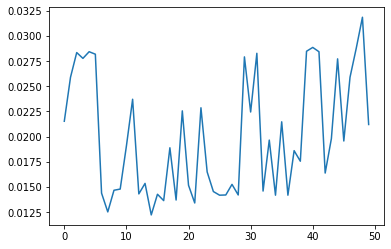

In [ ]:
plt.plot(attention[-1,:])

In [ ]:
attention[-1,:]

array([0.02151734, 0.0258859 , 0.02833957, 0.02776325, 0.02842387,
       0.02817683, 0.01437374, 0.01251296, 0.01466328, 0.01478098,
       0.01905748, 0.02370245, 0.01430107, 0.01534361, 0.01221397,
       0.01426638, 0.01363533, 0.01888262, 0.0136933 , 0.02254841,
       0.01515957, 0.0134002 , 0.02285535, 0.01648309, 0.01453597,
       0.01417305, 0.01419421, 0.01524857, 0.01419575, 0.02791079,
       0.02243683, 0.02826656, 0.01458396, 0.01964609, 0.01417289,
       0.02146074, 0.0141729 , 0.0185962 , 0.01754801, 0.02847057,
       0.02885048, 0.02842296, 0.01637199, 0.01979416, 0.02771469,
       0.01955647, 0.02589093, 0.02876147, 0.0318479 , 0.02119535],
      dtype=float32)

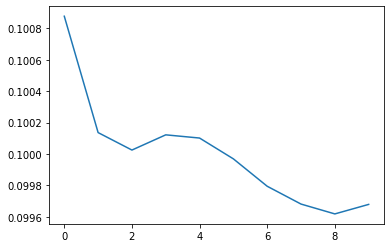

In [ ]:
plt.plot(temporal[-1])

In [ ]:
loss = nn.MSELoss()
with torch.no_grad():
    mse_val = 0
    preds = []
    true = []
    for batch_x, batch_y_h, batch_y in test_loader:
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        batch_y_h = batch_y_h.cuda()
        output, _,_ = model(batch_x, batch_y_h)
        output = output.squeeze(1)
        preds.append(output.detach().cpu().numpy())
        true.append(batch_y.detach().cpu().numpy())
        mse_val += loss(output, batch_y).item()*batch_x.shape[0]
preds = np.concatenate(preds)
true = np.concatenate(true)

In [ ]:
preds = preds*(target_train_max - target_train_min) + target_train_min
true = true*(target_train_max - target_train_min) + target_train_min
mse = mean_squared_error(true, preds)
mae = mean_absolute_error(true, preds)

In [ ]:
# evaluate 
evaluate(preds, true)

{'mape': 0.4906370770186186,
 'mda': 0.6613226452905812,
 'mdd': -1.4271676540374756,
 'mds': 0.12335559791457916,
 'mnda': 0.5333333333333333,
 'mnp': 0.7311827956989247,
 'mpda': 0.7950819672131147,
 'mpp': 0.6198083067092651,
 'pct_r': 111.88526550018176,
 'rmse': 0.8838319,
 'sr': 6.3345064061004415}

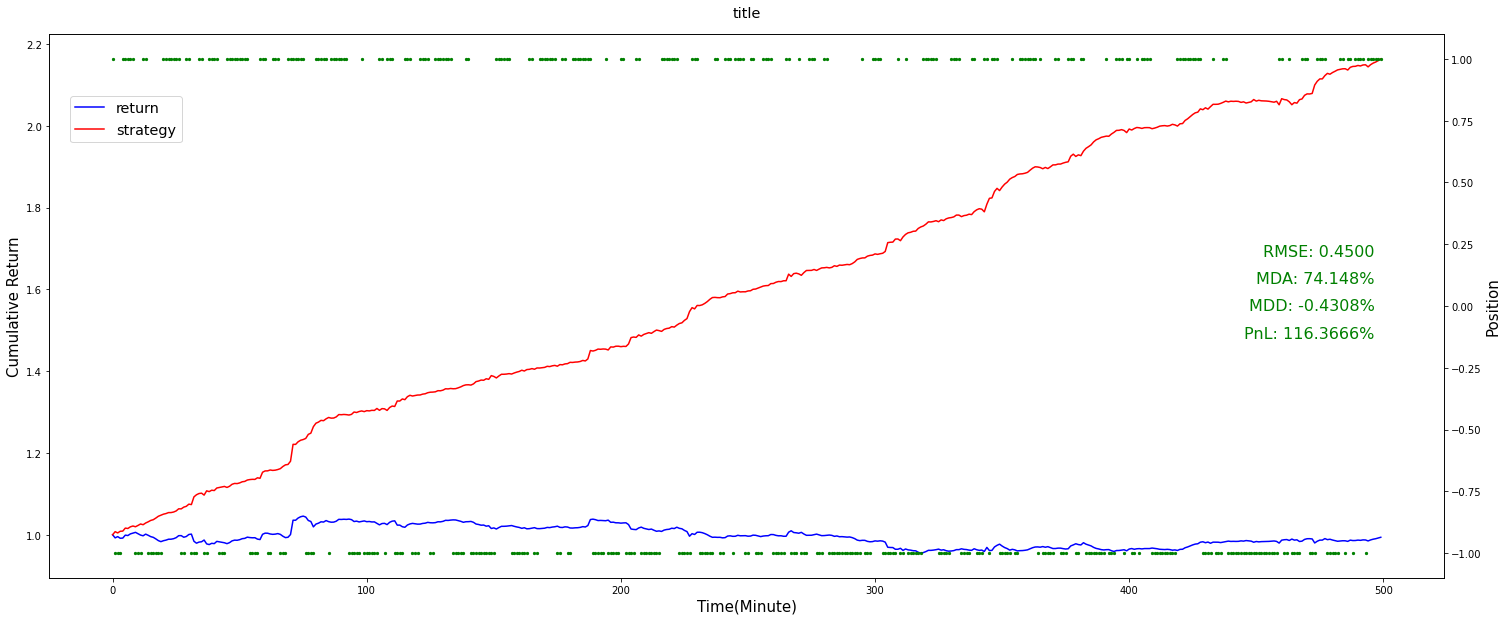

save plots ... 
SR_Annualized:  8.258795955221666
R2:  0.9752738457173109


In [ ]:
backtesting(preds, true)

In [ ]:
%cd "/content/drive/My Drive/Colab Notebooks/Result/Baseline_July"
with open('ibm_3min_OLS_best_july.txt',"rb") as fp:
    OLS_best = pickle.load(fp)
with open('ibm_3min_LR_best_july.txt',"rb") as fp:
    LR_best = pickle.load(fp)
with open('ibm_3min_RR_best_july.txt',"rb") as fp:
    RR_best = pickle.load(fp)
with open('ibm_3min_PCA_best_july.txt',"rb") as fp:
    PCA_best = pickle.load(fp) 
with open('IBM_3min_RFR_best_july.txt',"rb") as fp:
    RFR_best = pickle.load(fp) 

actual = PCA_best[0]
pca = PCA_best[1]
naive = actual[:-1]
ols = OLS_best[1]
lr = LR_best[1]
rr = RR_best[1]
rfr = RFR_best[1]

print(dm_test(actual[1:len(actual)], pca[1:len(actual)], ols[1:len(actual)]))
print(dm_test(actual[1:len(actual)], pca[1:len(actual)], lr[1:len(actual)]))
print(dm_test(actual[1:len(actual)], pca[1:len(actual)], rr[1:len(actual)]))
print(dm_test(actual[1:len(actual)], pca[1:len(actual)], rfr[1:len(actual)]))
print(dm_test(actual[1:len(actual)], pca[1:len(actual)], preds[1:len(actual)]))


/content/drive/My Drive/Colab Notebooks/Result/Baseline_July
dm_return(DM=-5.693297294816105, p_value=2.131328702908053e-08)
dm_return(DM=-5.771515068413579, p_value=1.3827152174237954e-08)
dm_return(DM=-1.741247421236947, p_value=0.082257745858044)
dm_return(DM=-4.7356589229348405, p_value=2.851114761450702e-06)
dm_return(DM=-1.272434745741382, p_value=0.2038124728670454)


In [ ]:
%cd "/content/drive/My Drive/Colab Notebooks/Result/Baseline_July"
with open('ibm_5min_OLS_best_july.txt',"rb") as fp:
    OLS_best = pickle.load(fp)
with open('ibm_5min_LR_best_july.txt',"rb") as fp:
    LR_best = pickle.load(fp)
with open('ibm_5min_RR_best_july.txt',"rb") as fp:
    RR_best = pickle.load(fp)
with open('ibm_5min_PCA_best_july.txt',"rb") as fp:
    PCA_best = pickle.load(fp) 
with open('IBM_5min_RFR_best_july.txt',"rb") as fp:
    RFR_best = pickle.load(fp) 

actual = PCA_best[0]
pca = PCA_best[1]
naive = actual[:-1]
ols = OLS_best[1]
lr = LR_best[1]
rr = RR_best[1]
rfr = RFR_best[1]

print(dm_test(actual[1:len(actual)], pca[1:len(actual)], ols[1:len(actual)]))
print(dm_test(actual[1:len(actual)], pca[1:len(actual)], lr[1:len(actual)]))
print(dm_test(actual[1:len(actual)], pca[1:len(actual)], rr[1:len(actual)]))
print(dm_test(actual[1:len(actual)], pca[1:len(actual)], rfr[1:len(actual)]))
print(dm_test(actual[1:len(actual)], pca[1:len(actual)], preds[1:len(actual)]))


/content/drive/My Drive/Colab Notebooks/Result/Baseline_July
dm_return(DM=-4.629589624602808, p_value=4.680652344242733e-06)
dm_return(DM=-2.779494303930849, p_value=0.005650253684525132)
dm_return(DM=-3.584058490094617, p_value=0.0003715891883973599)
dm_return(DM=-0.9371119473307478, p_value=0.3491552074815185)
dm_return(DM=-13.408840944478785, p_value=3.2002609694449245e-35)


In [ ]:
%cd "/content/drive/My Drive/Colab Notebooks/Result/Baseline_July"
with open('ibm_10min_OLS_best_july.txt',"rb") as fp:
    OLS_best = pickle.load(fp)
with open('ibm_10min_LR_best_july.txt',"rb") as fp:
    LR_best = pickle.load(fp)
with open('ibm_10min_RR_best_july.txt',"rb") as fp:
    RR_best = pickle.load(fp)
with open('ibm_10min_PCA_best_july.txt',"rb") as fp:
    PCA_best = pickle.load(fp) 
with open('IBM_10min_RFR_best_july.txt',"rb") as fp:
    RFR_best = pickle.load(fp) 

actual = PCA_best[0]
pca = PCA_best[1]
naive = actual[:-1]
ols = OLS_best[1]
lr = LR_best[1]
rr = RR_best[1]
rfr = RFR_best[1]

print(dm_test(actual[1:len(actual)], pca[1:len(actual)], ols[1:len(actual)]))
print(dm_test(actual[1:len(actual)], pca[1:len(actual)], lr[1:len(actual)]))
print(dm_test(actual[1:len(actual)], pca[1:len(actual)], rr[1:len(actual)]))
print(dm_test(actual[1:len(actual)], pca[1:len(actual)], rfr[1:len(actual)]))
print(dm_test(actual[1:len(actual)], pca[1:len(actual)], preds[1:len(actual)]))


/content/drive/My Drive/Colab Notebooks/Result/Baseline_July
dm_return(DM=-1.3677061481711104, p_value=0.17202095545662513)
dm_return(DM=-4.773753914523963, p_value=2.380637229655578e-06)
dm_return(DM=-0.8721278503865161, p_value=0.38355890839882356)
dm_return(DM=-6.0397695704208285, p_value=3.022190194669289e-09)
dm_return(DM=-0.4433515157166105, p_value=0.6577040398789201)


In [ ]:
%cd "/content/drive/My Drive/Colab Notebooks/Result/Baseline_July"
with open('ibm_15min_OLS_best_july.txt',"rb") as fp:
    OLS_best = pickle.load(fp)
with open('ibm_15min_LR_best_july.txt',"rb") as fp:
    LR_best = pickle.load(fp)
with open('ibm_15min_RR_best_july.txt',"rb") as fp:
    RR_best = pickle.load(fp)
with open('ibm_15min_PCA_best_july.txt',"rb") as fp:
    PCA_best = pickle.load(fp) 
with open('IBM_15min_RFR_best_july.txt',"rb") as fp:
    RFR_best = pickle.load(fp) 

actual = PCA_best[0]
pca = PCA_best[1]
naive = actual[:-1]
ols = OLS_best[1]
lr = LR_best[1]
rr = RR_best[1]
rfr = RFR_best[1]

print(dm_test(actual[1:len(actual)], pca[1:len(actual)], ols[1:len(actual)]))
print(dm_test(actual[1:len(actual)], pca[1:len(actual)], lr[1:len(actual)]))
print(dm_test(actual[1:len(actual)], pca[1:len(actual)], rr[1:len(actual)]))
print(dm_test(actual[1:len(actual)], pca[1:len(actual)], rfr[1:len(actual)]))
print(dm_test(actual[1:len(actual)], pca[1:len(actual)], preds[1:len(actual)]))


/content/drive/My Drive/Colab Notebooks/Result/Baseline_July
dm_return(DM=-2.04396098616539, p_value=0.04148291073000449)
dm_return(DM=-2.410978566297484, p_value=0.016270887420154916)
dm_return(DM=-1.5366521608970045, p_value=0.12501359184800637)
dm_return(DM=-2.843801036362711, p_value=0.004641193184693165)
dm_return(DM=-1.175618473794042, p_value=0.2403090955505947)
